# QNN MNIST Classification
使用 QNN 來進行手寫數字 0 與 1 的分類。\
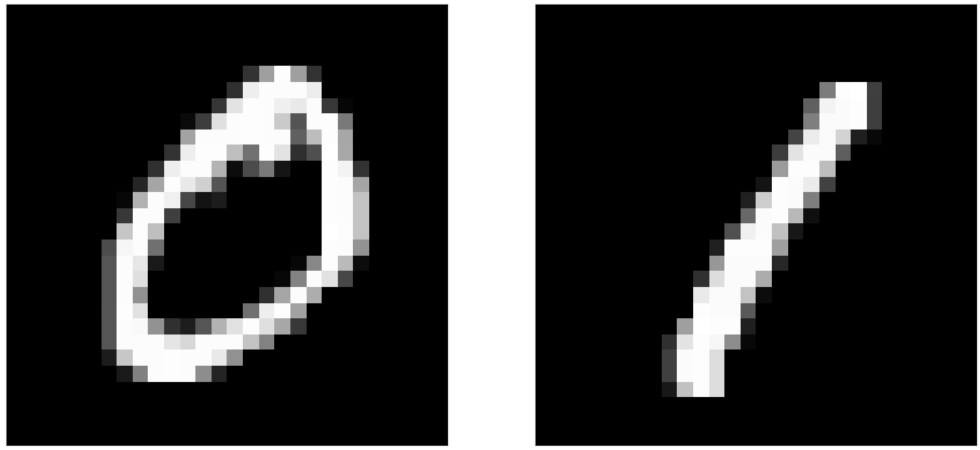


量子神經網路(QNN)就如同古典上的神經網路(ANN)一樣，目標都是讓模型利用參數的交互來學習數據特徵，來達成某種目的 (例如進行分類、生成資料等等) \
* ANN 使用古典位元 (0 與 1) 與數學運算 (例如矩陣乘法 $W \cdot x + b$) 來達成 \
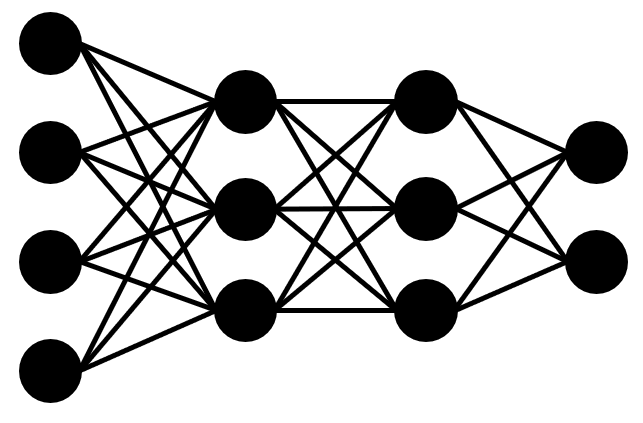
* QNN 使用量子位元 (可處在 0 與 1 的疊加態) 與參數化量子電路 (PQC) 來達成 \
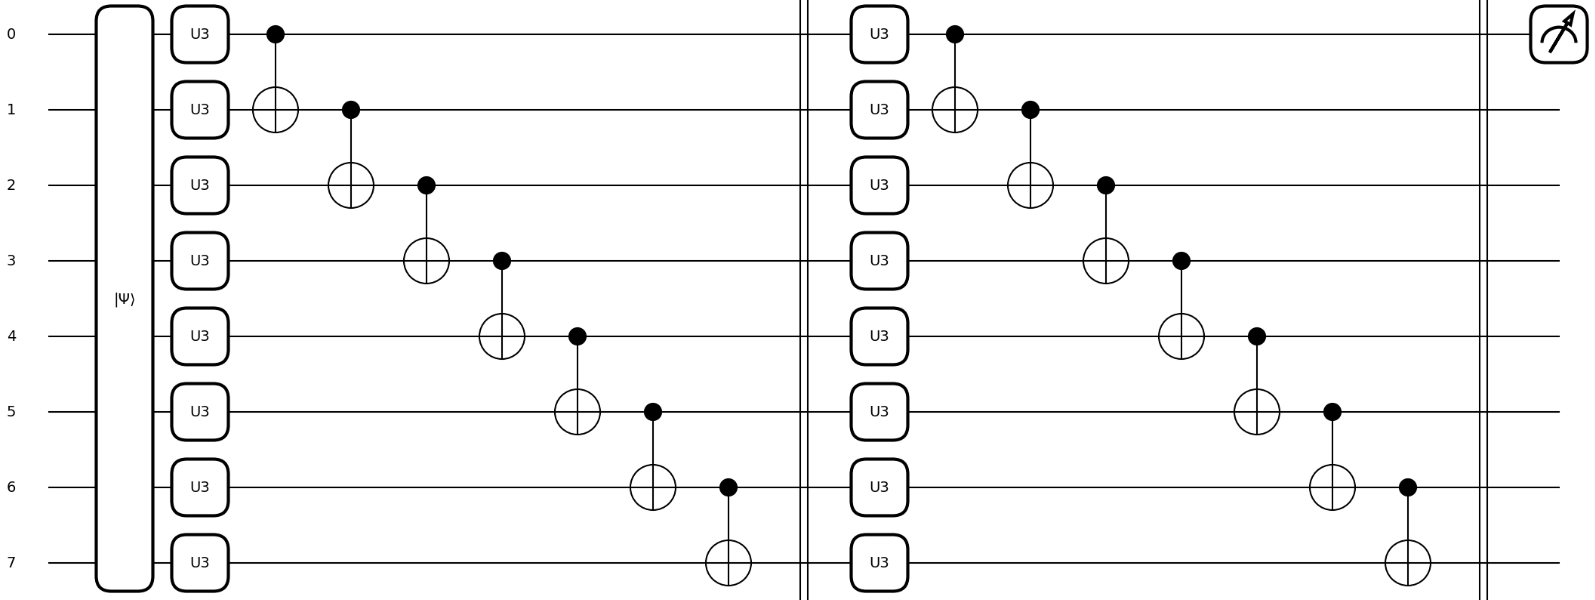



# 下載必要函式庫

In [ ]:
!pip install pennylane          # PennyLane 是一個專門為「量子計算」設計的開源 Python 軟體庫
!pip install scikit-learn       # 用於處理一些傳統機器學習的任務，包含一些基礎的資料讀取分割功能 (後續程式碼將會使用到)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 49.8 MB/s eta 0:00:00


# 讀取必要函式庫

In [ ]:
import pennylane as qml                                 # pennylane 量子模型庫
from pennylane import numpy as np                       # pennylane 自帶的 numpy 庫，numpy 大幅改善了 python 數值計算緩慢的問題

import matplotlib.pyplot as plt                         # 在這裡用於畫折線圖、顯示圖片

from sklearn.datasets import fetch_openml               # 用於讀取 MNIST 數據
from sklearn.decomposition import PCA                   # 用於數據降維
from sklearn.model_selection import train_test_split    # 用於資料自動分割
from sklearn.preprocessing import MinMaxScaler          # 用於縮放數據範圍
from skimage.transform import resize                    # 調整圖片長寬大小

# 輸入 MNIST 數據
MNIST (Modified National Institute of Standards and Technology database) 是一個大型的手寫數字資料庫。包含 0 到 9 的手寫數字圖片。
* 訓練集 (Training Set)：60,000 張
* 測試集 (Test Set)：10,000 張
* 解析度：原始尺寸為 $28 \times 28$ 像素的圖片。
* 色彩：灰階 (Grayscale)。每個像素的值介於 $0$（黑色）到 $255$（白色）之間。

正在下載並處理 MNIST 資料...
x data shape:  (14780, 784)
y data shape:  (14780,)


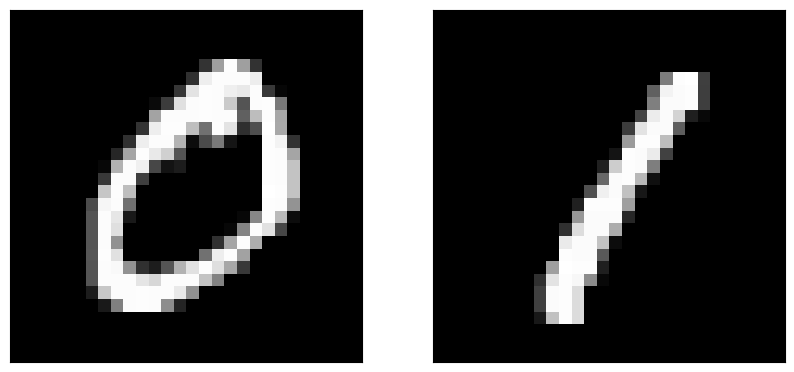

In [ ]:
# 1. 載入並預處理資料
print("正在下載並處理 MNIST 資料...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
x, y = mnist.data, mnist.target

# 只篩選手寫數字 0 和 1
mask = (y == '0') | (y == '1')
x, y = x[mask], y[mask].astype(int)
print("x data shape: ", x.shape)
print("y data shape: ", y.shape)

# 查看手寫數字圖片
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(x[0].reshape(28, 28), cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(x[1].reshape(28, 28), cmap='gray')
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

# 數據預處理：
1. 使用 PCA 將 MNIST 數據從 784(28*28) 維降維成 8 維
> 由於速度因素與模擬的限制，避免使用太多 qubits。\
降維後會將數值 [0, 255] 縮放到 [0, pi] 中。
2. 將 MNIST 數據的圖片從 28 * 28 的圖片縮放成 16 * 16
>   這是當使用 Amplitude Embedding 時的做法，因為 Amplitude Embedding 能夠支援 $2^N$ 個 input 特徵 (N 是 qubit 的數量)，8 個 qubits 代表可以容納 $2^8=16*16=256$ 個特徵。



In [ ]:
# Data Preprocessing
# PCA 降維至 8 維
pca = PCA(n_components=8)
x_pca = pca.fit_transform(x)
# 標準化 (將數據縮放至 [0, pi] 以符合量子閘角度範圍)
scaler = MinMaxScaler(feature_range=(0, np.pi))
x_pca = scaler.fit_transform(x_pca)
print("x_pca shape", x_pca.shape)


# 28 * 28 的圖片縮放成 16 * 16 : 要使用時取消註解 (選取要註解的程式碼 -> Ctrl+/)
# x_scaled = []
# x_image = x.reshape(len(x), 28, 28)   # 將 x reshape 成 [data個數, 28, 28]
# for i in range(len(x)):
#     x_scaled.append(resize(x_image[i], (16, 16), anti_aliasing=True))
# x_scaled = np.stack(x_scaled, axis = 0).reshape(len(x_image), 256)
# print("x_scaled shape:", x_scaled.shape)
# # 查看手寫數字圖片
# plt.imshow(x_scaled[0].reshape(16, 16), cmap='gray')
# plt.show()

x_pca shape (14780, 8)


In [ ]:
# 切分訓練與測試集，取訓練集 1000 筆，測試集 250 筆
# PCA 降維數據，注: 當 random_state 一樣時，每次都會是切分到一樣的 data
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, train_size=1000, test_size=250, random_state=42)

# 縮放圖片至 16*16 數據 : 要使用時取消註解
#x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, train_size=1000, test_size=250, random_state=42)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("\n * 注意要確認數據 shape 正不正確")

x_train shape: (1000, 8)
x_test shape: (250, 8)

 * 注意要確認數據 shape 正不正確


# 建構量子電路
其核心流程可分為三個階段：
1. 初始狀態準備 (State Preparation)
2. 參數化電路 (Parameterized circuit)
3. 量測 (Measurement)

如果是要做一個分類任務 (比如目前的手寫數字 0、1 分類) \
首先要先將要分類的 data 特徵丟到模型中 -> 初始狀態準備 \
目前有需多種方式可以達成此目的
1. Angle Embedding (角度嵌入)
   * 作法：將古典特徵向量 $\mathbf{x} = [x_1, x_2, ..., x_n]$ 的每一個分量映射為一個量子位元的旋轉角度(使用 $R_x, R_y$ 或 $R_z$ 閘)
    * Qubit 消耗：$N$ 個特徵需要 $N$ 個量子位元
2. ZZ Feature Map
   * 作法：除了對單個位元進行旋轉 (Angle Embedding)，還會根據兩兩特徵的乘積 (例如 $x_i \cdot x_j$ ) 施加受控相位移動（$ZZ$ 交互作用）。
    * Qubit 消耗：$N$ 個特徵需要 $N$ 個量子位元。
3. Amplitude Embedding (幅度嵌入)
    * 作法：將整個古典向量 $\mathbf{x}$ 歸一化後，直接作為量子態的機率振幅(Amplitudes)。
    * Qubit 消耗：$N$ 維特徵只需要 $\lceil \log_2 N \rceil$ 個量子位元。例如：8 維數據只需 3 個 Qubits。

接下來是分類任務的核心 -> 參數化電路
* 想要分類的好，必須要有符合數學邏輯的設計，可以看以下程式碼的範例
最後是量測
> 這個程式碼使用的是 qml.probs\
它的作用是計算量子位元在觀測後，處於各個 基態 (Basis States) 的 機率分佈。
比如說有一個 qubit 的 state 為 $\vert \psi \rangle = a \vert 0 \rangle + b \vert 1 \rangle$ \
輸出的結果就會是 $[測量為 \vert 0 \rangle 的機率, 測量為 \vert 1 \rangle 的機率] = [|a|^2, |b|^2]$



# 以下的參數化電路是使用 HEA 結構

(<Figure size 2200x900 with 1 Axes>, <Axes: >)

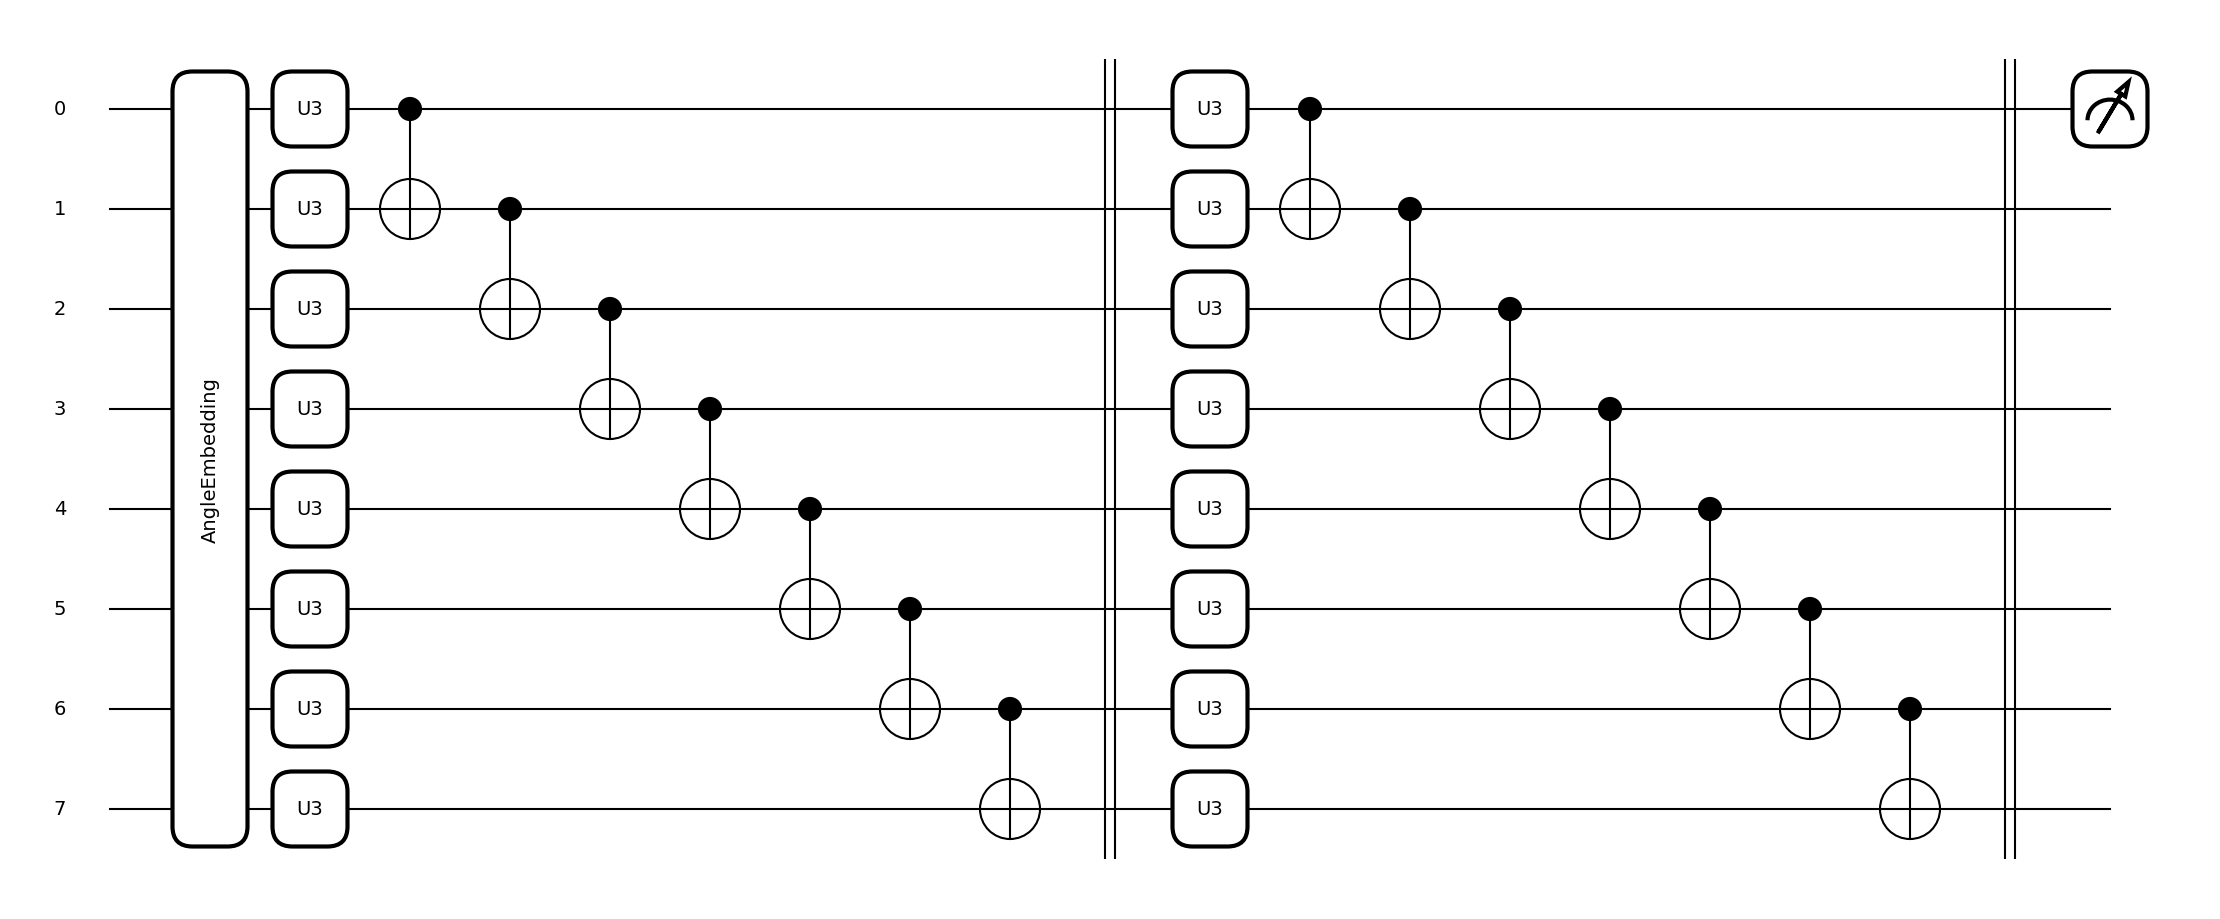

In [ ]:
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def circuit(num_layers, weights, features):
    # 將 8 維特徵編碼到 8 個 Qubits
    qml.AngleEmbedding(features, wires=range(n_qubits))

    # 將 256 維特徵編碼到 8 個 Qubits
    # qml.AmplitudeEmbedding(features, wires=range(n_qubits), normalize=True)

    # 變分層 (可重複堆疊增加複雜度)
    c = 0
    for i in range(num_layers):
        # 這裡會再單個 qubit 進行一個完整的 unitary 旋轉 (可以想像成在單個 qubit 的 bloch sphere 中轉到任何方向)
        for j in range(n_qubits):
            qml.U3(weights[c], weights[c+1], weights[c+2], wires=j)
            c += 3
        # 這裡是一個全連結的糾纏層，讓 qubit 與 qubit 之間所取得的特徵進行交互
        for j in range(n_qubits - 1):
            qml.CNOT(wires=[j, j + 1])
        qml.Barrier()


    # 量測，這將會回傳有兩個數值的 list，分別是 -> [測量為 |0> 的機率, 測量為 |1> 的機率]
    return qml.probs(wires=0)


# 初始化參數
num_layers = 2 # 層數

# 計算 parameter 數量
num_parameters = num_layers * 8 * 3     # 8 個 qubits, 每個 qubit 3 個參數

# 隨機生成可訓練的參數，數值範圍 [low, high] 在 [-pi, pi] 之間，長度為 size
weights = np.random.uniform(low = -np.pi, high = np.pi, size = num_parameters, requires_grad=True)

# 畫出電路圖
qml.draw_mpl(circuit)(num_layers, weights, x_train[0])

# 以下的參數化電路是使用 QCNN 結構

(<Figure size 5700x900 with 1 Axes>, <Axes: >)

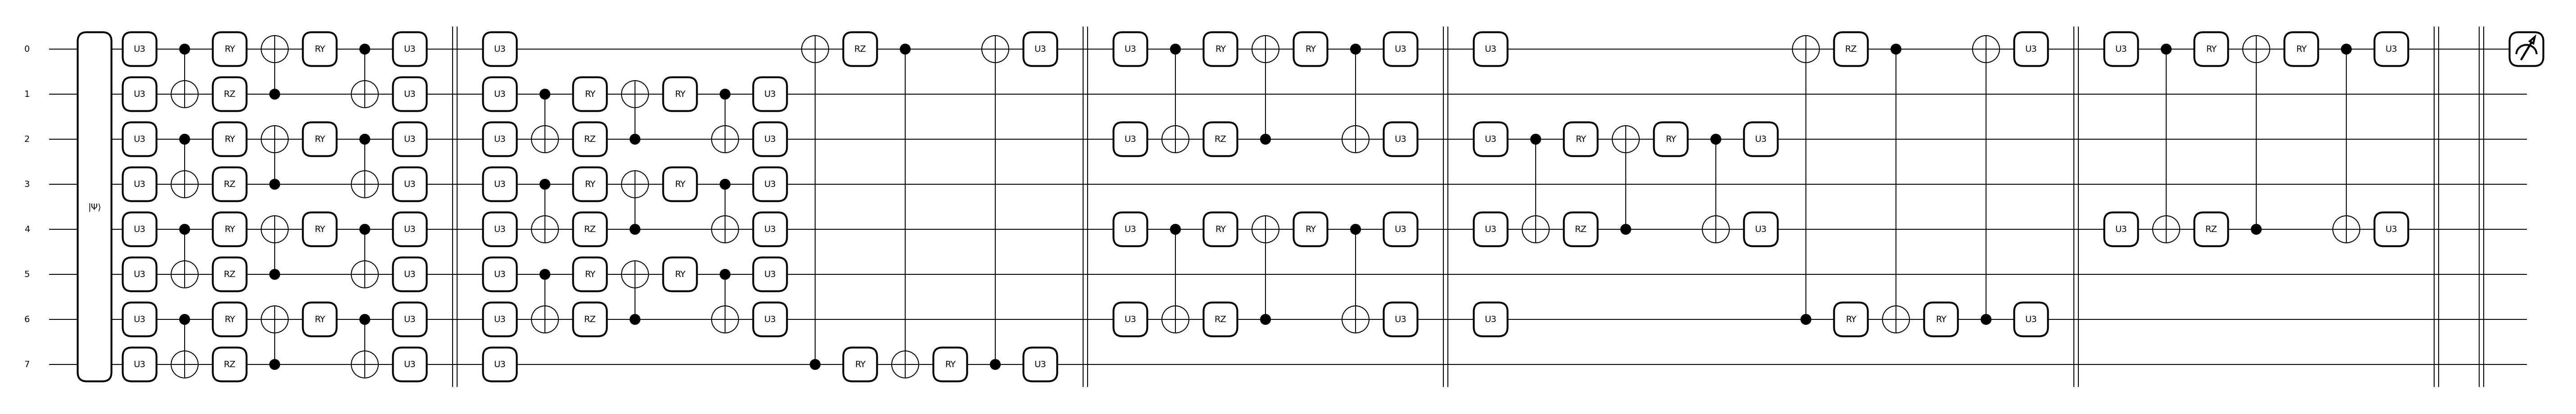

In [ ]:
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

def Block(weights, wires):  # 15 個參數
    qml.U3(weights[0], weights[1], weights[2], wires=wires[0])
    qml.U3(weights[3], weights[4], weights[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(weights[6], wires=wires[0])
    qml.RZ(weights[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(weights[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(weights[9], weights[10], weights[11], wires=wires[0])
    qml.U3(weights[12], weights[13], weights[14], wires=wires[1])

@qml.qnode(dev)
def circuit(num_layers, weights, features):
    # 將 8 維特徵編碼到 8 個 Qubits
    # qml.AngleEmbedding(features, wires=range(n_qubits))

    # 將 256 維特徵編碼到 8 個 Qubits
    qml.AmplitudeEmbedding(features, wires=range(n_qubits), normalize=True)

    # 變分層 (可重複堆疊增加複雜度)
    c = 0
    for i in range(num_layers):
        target_qubit = [j*(2**i) for j in range(8//(2**i))]
        for j in range(len(target_qubit)//2):
            Block(weights[c:c+15], wires = [target_qubit[j*2],target_qubit[j*2+1]])
        qml.Barrier()
        if i != 2:
            for j in range(len(target_qubit)//2):
                Block(weights[c:c+15], wires = [target_qubit[j*2+1],target_qubit[(j*2+2) % (8//(2**i))]])
        c += 15
        qml.Barrier()


    # 量測，這將會回傳有兩個數值的 list，分別是 -> [測量為 |0> 的機率, 測量為 |1> 的機率]
    return qml.probs(wires=0)


# 初始化參數
num_layers = 3  # 層數

# 計算 parameter 數量
num_parameters = num_layers * 15     # 每層使用 4 個參數

# 隨機生成可訓練的參數，數值範圍 [low, high] 在 [-pi, pi] 之間，長度為 size
weights = np.random.uniform(low = -np.pi, high = np.pi, size = num_parameters, requires_grad=True)

# 畫出電路圖
qml.draw_mpl(circuit)(num_layers, weights, x_train[0])

# 定義損失函數
QNN 與 ANN 中，損失函數 (Loss Function) 是衡量模型表現的核心工具
* Loss 是用來測量模型的預測結果與真實標籤之間的差距，所以這個數值越小越好
* 模型可以根據 Loss 來優化參數權重 (weights)，使下次的預測結果更貼近真實標籤
* 以下使用 均方誤差 (Mean Squared Error, MSE) 來進行 Loss 計算
$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$
預測值 ($\hat{y}$)：模型根據輸入資料算出來的答案。真實值 ($y$)：資料集標註的正確答案，n: data 的個數。\
以下是 Loss 與 weight 之間的關聯，我們需要找到的是"全局最優解"的位置 \
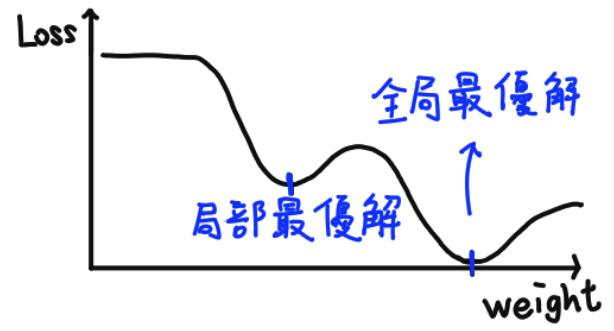



In [ ]:
def loss_func(weights, x, y):
    # 將 data 與要訓練的權重丟到量子模型當中，並且只拿 "測量為 |1> 的機率"
    # 因此當 "測量為 |1> 的機率" 為 1，將會於手寫數字 1 做對應
    # 反之當 "測量為 |1> 的機率" 為 0，將會於手寫數字 0 做對應
    predictions = np.array([circuit(num_layers, weights, data)[1] for data in x])

    # 使用平方誤差 (MSE) 損失函數 -> 用來檢測量子模型預測的與真實結果的差距，我們會希望這個數值越小越好
    loss = np.mean((predictions - y)**2)

    # 回傳損失函數
    return loss

# 訓練 QNN 模型
* 優化器 (Optimizer)：在訓練 QNN 或 ANN 模型時，需要選擇合適的數學機制來更新參數權重 (Weights)，此機制即為優化器 (Optimizer)。本研究選用 AdamOptimizer，利用其自適應學習率的特性來提升優化效率。
* 學習率 (Learning Rate)：每次優化的步長。若設定過大，模型容易跳過全局最優解而產生震盪；若設定過小，則會導致收斂緩慢，且容易陷入局部最優解 (Local Minima)。
* 批次大小 (Batch Size)：考量到數據量龐大，訓練過程採用分批訓練 (Mini-batch Training)。其中 Batch Size 代表每次參數更新時所使用的樣本數量，能有效平衡計算效率與內存負荷。

開始訓練量子模型...
Step   5 | Loss: 0.0183
Step  10 | Loss: 0.0347
Step  15 | Loss: 0.0253
Step  20 | Loss: 0.0242
Step  25 | Loss: 0.0355
Step  30 | Loss: 0.0358
Step  35 | Loss: 0.0157
Step  40 | Loss: 0.0300

測試集準確度: 98.40%


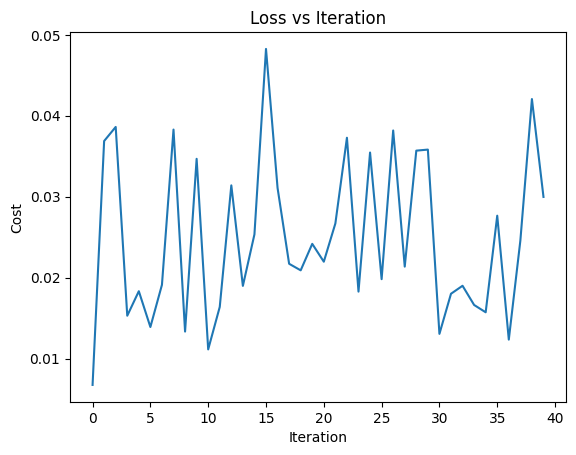

In [ ]:
# 4. 開始訓練
# 設定超參數與優化器
iterations = 40         # 訓練次數
batch_size = 10         # 每次訓練所使用的 data 數量
learning_rate = 0.01    # 每次更新參數的步長
opt = qml.AdamOptimizer(stepsize=learning_rate)     # 利用梯度下降優化器
loss_list = []                                      # 用於紀錄 loss 數值的變化

print("開始訓練量子模型...")
for it in range(iterations):
    # 隨機抽樣 batch_size 個 data
    batch_index = np.random.randint(0, len(x_train), (batch_size,))
    x_batch = x_train[batch_index]
    y_batch = y_train[batch_index]

    # loss_func 中會把每個 data 分別丟到量子電路當中，並計算 loss(損失)
    weights, loss = opt.step_and_cost(lambda w: loss_func(w, x_batch, y_batch), weights)
    loss_list.append(loss)

    if (it + 1) % 5 == 0:
        print(f"Step {it+1:3d} | Loss: {loss:.4f}")

# 5. 測試準確度
def predict(weights, x):
    # 將 data 與訓練完成的權重丟到量子模型當中，並且只拿 "測量為 |1> 的機率"
    predictions = [circuit(num_layers, weights, data)[1] for data in x]

    # 如果 predictions 數值大於 0.5 將會被視為是手寫數字 1，小於 0.5 將會被視為是手寫數字 0
    return [1 if prediction > 0.5 else 0 for prediction in predictions]

y_pred = predict(weights, x_test)
accuracy = np.mean(y_pred == y_test)
print(f"\n測試集準確度: {accuracy * 100:.2f}%")


# loss 變化折線圖
plt.plot(loss_list)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Loss vs Iteration")
plt.show()